In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import time
import pandas as pd

In [166]:
plt.rcParams.update({'font.size': 14})

## Func Integrate

In [3]:
def integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    snMea_list = [None]*len(CorMea)

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        
        op_list[n] = sx
        sx_list.append( tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    for l,m in enumerate(CorMea):
        snMea_list[l] = []
        sn = [s.data[0,0]*sx+s.data[1,0]*sy+s.data[2,0]*sz if s is not None else None for s in m]
        ind = [i for i in range(len(sn)) if sn[i]!=None]
        for n in range(N-len(sn)+1):
            op_list = []
            for m in range(N):
                op_list.append(si)
            for j in ind:
                op_list[n+j] = sn[j]
            snMea_list[l].append(tensor(op_list))
        
    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H += - 0.5 * Bz[n] * sz_list[n]
        H += - 0.5 * Bx[n] * sx_list[n]
        
        
    # interaction terms
    for n in range(N-1):
        H += - 0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
        H += - 0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
        H += - 0.5 * Jz[n] * sz_list[n] * sz_list[n+1]

    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(N):
        if gamma[n] > 0.0:
            c_op_list.append(np.sqrt(gamma[n]) * sz_list[n])
    
    # evolve and calculate expectation values
    if solver == "me":
        results = np.empty(len(snMea_list),dtype=object)
        for i,j in enumerate(snMea_list):
            results[i] = np.array(mesolve(H, psi0, tlist, c_op_list, j).expect)
    elif solver == "mc":
        ntraj = 250 
        results = mcsolve(H, psi0, tlist, c_op_list, MB, ntraj)

    return (results)

## Main

## Ramsey/echo

### Clean case

In [73]:
start_time = time.time()
solver = "me"   # use the ode solver
N = 5            # number of spins
Sbasis = Qobj([[0],[1],[0]]).unit() #sigmax, sigmay, sigmaz
CorMea = [
            [Sbasis,Sbasis],
            [Sbasis],
         ]
Nran = np.random.rand(1)
ResExp = np.empty(len(Nran), dtype=object)
for i,rani in enumerate(Nran):
    if (i+1)%10 == 0:
        print('\r',i,end='')
    # array of spin energy splittings and coupling strengths. here we use
    # uniform parameters, but in general we don't have too
    Bx = 0.0 * np.ones(N)
    Bz = 0.0 * np.ones(N)
    Jz = 1.0 * np.ones(N)
    Jx = 0.0 * np.ones(N)
    Jy = 0.0 * np.ones(N)
    # dephasing rate
    gamma = 0.0 * np.ones(N)

    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    # psi_list.append((basis(2, 0) + basis(2, 1)).unit())

    for n in range(N):
        # psi_list.append(basis(2,0)) #up |0>
#         psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # |x>
        psi_list.append((basis(2, 0) - 1j*basis(2, 1)).unit()) # |y>

    psi0 = tensor(psi_list)

    tlist = np.linspace(0, 12, 500)
    # 
    ResExp[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea)
print("--- %0.4f seconds ---" % (time.time() - start_time))

--- 0.1471 seconds ---


(-0.1, 0.3)

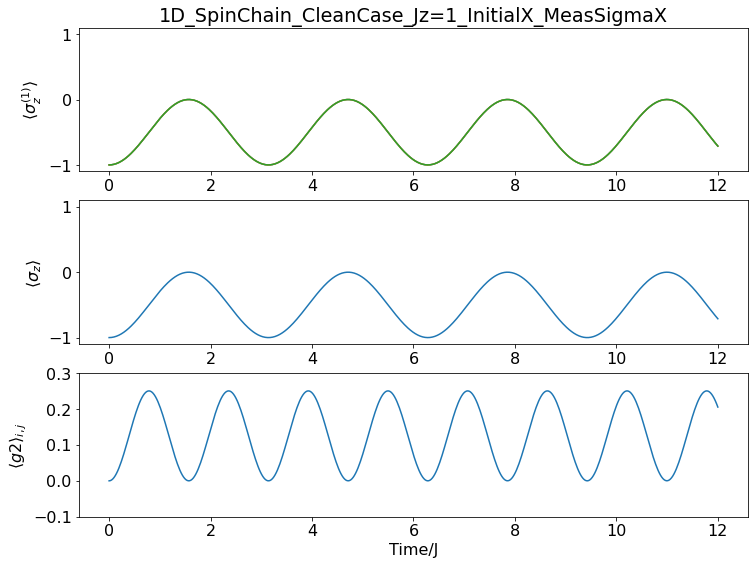

In [74]:
ReSide = 1

g2=np.empty(len(Nran), dtype=object)
Meas=np.empty(len(Nran), dtype=object)
for i in range(len(Nran)):
    g2[i] = ResExp[i][0][ReSide:N-1-ReSide]-ResExp[i][1][ReSide:N-1-ReSide]*ResExp[i][1][1+ReSide:N-ReSide]
    Meas[i] = ResExp[i][1][ReSide:N-ReSide]
MeasClean = Meas[0][0]
MeasAvgClean = (Meas.mean(axis=0)).mean(axis=0)
g2AvgClean = (g2.mean(axis=0)).mean(axis=0)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,9))
for n in range(len(Meas[0])):
    ax1.plot(tlist, Meas[0][n])

ax2.plot(tlist, MeasClean)
ax3.plot(tlist, g2Clean)
ax3.set_xlabel('Time/J')
ax1.set_ylabel(r'$\langle\sigma_z^{(1)}\rangle$')
ax2.set_ylabel(r'$\langle\sigma_z\rangle$')
ax3.set_ylabel(r'$\langle g2\rangle_{i,j}$')

ax1.set_title('1D_SpinChain_CleanCase_Jz=1_InitialX_MeasSigmaX');
ax1.set_ylim([-1.1,1.1])
ax2.set_ylim([-1.1,1.1])
ax3.set_ylim([-0.1,0.3])

### Apply global phase $B_z$

In [37]:
start_time = time.time()
#
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver

N = 5            # number of spins

Sbasis = Qobj([[1],[0],[0]]).unit() #sigmax, sigmay, sigmaz
CorMea = [
            [Sbasis,Sbasis],
            [Sbasis],
         ]

Nran = np.random.rand(50)
ResExp = np.empty(len(Nran), dtype=object)
for i,rani in enumerate(Nran):
    if (i+1)%10 == 0:
        print('\r',i+1,end='')
    # array of spin energy splittings and coupling strengths. here we use
    # uniform parameters, but in general we don't have too
    Bx = 0.0 * np.ones(N)
    Bz = 1.0 * np.ones(N)*(rani)
    Jz = 1.0 * np.ones(N)
    Jx = 0.0 * np.ones(N)
    Jy = 0.0 * np.ones(N)
    
    # dephasing rate
    gamma = 0.00 * np.ones(N)

    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    # psi_list.append((basis(2, 0) + basis(2, 1)).unit())

    for n in range(N):
        # psi_list.append(basis(2,0)) #up |0>
        psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # |x>
        # psi_list.append((basis(2, 0) + 1j*basis(2, 1)).unit()) # |y>

    psi0 = tensor(psi_list)

    tlist = np.linspace(0, 12, 500)
    # 
    ResExp[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea)
print("--- %0.4f seconds ---" % (time.time() - start_time))

 50--- 5.5522 seconds ---


(-0.1, 0.3)

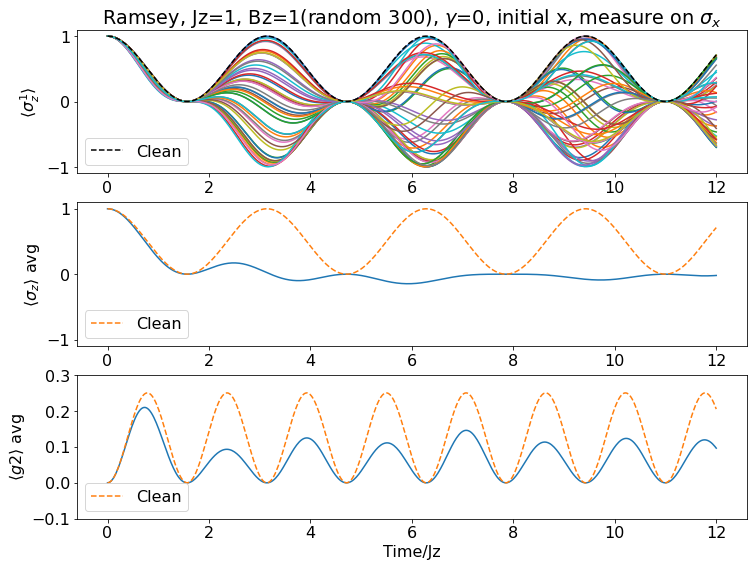

In [39]:
ReSide = 1

g2=np.empty(len(Nran), dtype=object)
Meas=np.empty(len(Nran), dtype=object)
for i in range(len(Nran)):
    g2[i] = ResExp[i][0][ReSide:N-1-ReSide]-ResExp[i][1][ReSide:N-1-ReSide]*ResExp[i][1][1+ReSide:N-ReSide]
    Meas[i] = ResExp[i][1][ReSide:N-ReSide]
g2Avg = (g2.mean(axis=0)).mean(axis=0)
MeasAvg = (Meas.mean(axis=0)).mean(axis=0)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,9))
for n in range(len(Meas)):
    ax1.plot(tlist, Meas[n][0])
ax2.plot(tlist, MeasAvg)
ax3.plot(tlist, g2Avg)

ax1.plot(tlist, MeasClean,'k--', label='Clean')
ax2.plot(tlist, MeasAvgClean,'--', label='Clean')
ax3.plot(tlist, g2AvgClean,'--', label='Clean')

ax1.legend()
ax2.legend()
ax3.legend()
ax3.set_xlabel('Time/Jz')
ax1.set_ylabel(r'$\langle\sigma_x^{1}\rangle$')
ax2.set_ylabel(r'$\langle\sigma_x\rangle$ avg')
ax3.set_ylabel(r'$\langle g2\rangle$ avg')

ax1.set_title('Ramsey, Jz=1, Bz=1(random 300), $\gamma$=0, initial x, measure on $\sigma_x$');
ax1.set_ylim([-1.1,1.1])
ax2.set_ylim([-1.1,1.1])
ax3.set_ylim([-0.1,0.3])

## Cluster state correlation

### Clean case

In [203]:
start_time = time.time()
#
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver

N = 6            # number of spins

Sbasis = Qobj([[0],[1],[0]]).unit() #sigmax, sigmay, sigmaz
CorMea = [
            [Sbasis,Sbasis],
            [Sbasis],
            [Qobj([[0],[0],[1]]),Sbasis,Qobj([[0],[0],[1]])],
         ]

Nran = np.random.rand(1)
ResExp = np.empty(len(Nran), dtype=object)
for i,rani in enumerate(Nran):
    if (i+1)%10 == 0:
        print('\r',i+1,end='')
    # array of spin energy splittings and coupling strengths. here we use
    # uniform parameters, but in general we don't have too
    Bx = 0.0 * np.ones(N)
    Bz = 0.0 * np.ones(N)
    Jz = 1.0 * np.ones(N)
    Jx = 0.0 * np.ones(N)
    Jy = 0.0 * np.ones(N)
    
    # dephasing rate
    gamma = 0.00 * np.ones(N)

    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    # psi_list.append((basis(2, 0) + basis(2, 1)).unit())

    for n in range(N):
        # psi_list.append(basis(2,0)) #up |0>
#         psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # |x>
        psi_list.append((basis(2, 0) - 1j*basis(2, 1)).unit()) # |y>

    psi0 = tensor(psi_list)

    tlist = np.linspace(0, 12, 500)
    # 
    ResExp[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea)
print("--- %0.4f seconds ---" % (time.time() - start_time))

--- 0.2161 seconds ---


(-0.1, 1.1)

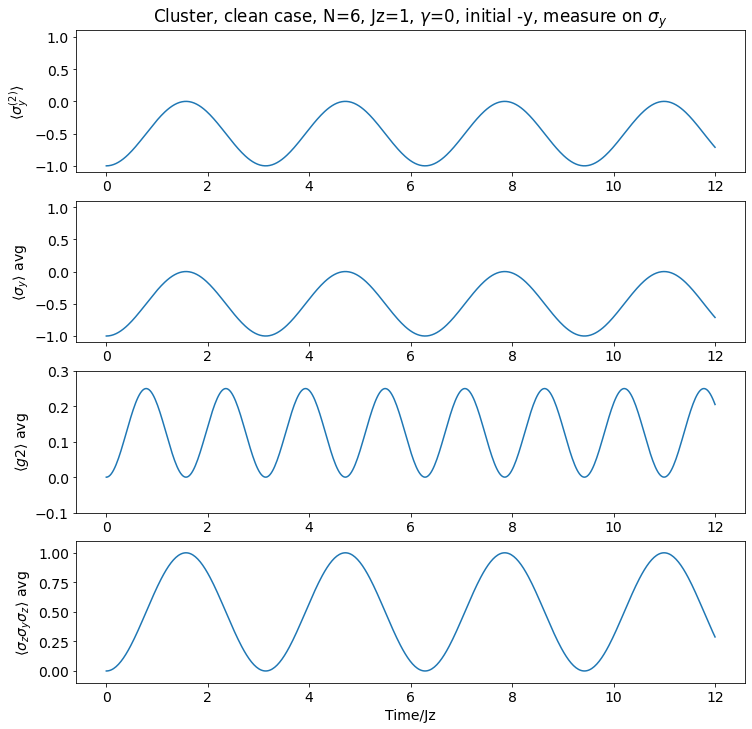

In [204]:
ReSide = 1

g2=np.empty(len(Nran), dtype=object)
Meas=np.empty(len(Nran), dtype=object)
K=np.empty(len(Nran), dtype=object)
for i in range(len(Nran)):
    Meas[i] = ResExp[i][1][ReSide:N-ReSide]
    g2[i] = ResExp[i][0][ReSide:N-1-ReSide]-ResExp[i][1][ReSide:N-1-ReSide]*ResExp[i][1][1+ReSide:N-ReSide]
    K[i] = ResExp[i][2][ReSide:N-ReSide]
MeasAvgClean = Meas.mean(axis=0).mean(axis=0)
g2AvgClean = g2.mean(axis=0).mean(axis=0)
KAvgClean = K.mean(axis=0).mean(axis=0)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,12))
for n in range(len(Meas)):
    ax1.plot(tlist, Meas[n][0])
ax2.plot(tlist, MeasAvgClean)
ax3.plot(tlist, g2AvgClean)
ax4.plot(tlist, KAvgClean)

ax4.set_xlabel('Time/Jz')
ax1.set_ylabel(r'$\langle\sigma_y^{(2)}\rangle$')
ax2.set_ylabel(r'$\langle\sigma_y\rangle$ avg')
ax3.set_ylabel(r'$\langle g2\rangle$ avg')
ax4.set_ylabel(r'$\langle \sigma_z\sigma_y\sigma_z\rangle$ avg')

ax1.set_title('Cluster, clean case, N=6, Jz=1, $\gamma$=0, initial -y, measure on $\sigma_y$');
ax1.set_ylim([-1.1,1.1])
ax2.set_ylim([-1.1,1.1])
ax3.set_ylim([-0.1,0.3])
ax4.set_ylim([-0.1,1.1])

# fig.savefig('Outputs/ClusterCorr/'+'Cluster_clean_N=6_Jz=1_gamma=0_initial-y_measure_sigma_y.png', dpi=100)

### Apply global phase $B_z$

#### Measurement $\langle \sigma_y \rangle$

In [205]:
start_time = time.time()
#
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver

N = 6            # number of spins

Sbasis = Qobj([[0],[1],[0]]).unit() #sigmax, sigmay, sigmaz
CorMea = [
            [Sbasis,Sbasis],
            [Sbasis],
            [Qobj([[0],[0],[1]]),Sbasis,Qobj([[0],[0],[1]])],
         ]

Nran = np.random.rand(300)
ResExp = np.empty(len(Nran), dtype=object)
for i,rani in enumerate(Nran):
    if (i+1)%10 == 0:
        print('\r',i+1,end='')
    # array of spin energy splittings and coupling strengths. here we use
    # uniform parameters, but in general we don't have too
    Bx = 0.0 * np.ones(N)
    Bz = 1.0 * np.ones(N)*(rani)
    Jz = 1.0 * np.ones(N)
    Jx = 0.0 * np.ones(N)
    Jy = 0.0 * np.ones(N)
    
    # dephasing rate
    gamma = 0.00 * np.ones(N)

    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    # psi_list.append((basis(2, 0) + basis(2, 1)).unit())

    for n in range(N):
        # psi_list.append(basis(2,0)) #up |0>
#         psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # |x>
        psi_list.append((basis(2, 0) - 1j*basis(2, 1)).unit()) # |y>

    psi0 = tensor(psi_list)

    tlist = np.linspace(0, 12, 500)
    # 
    ResExp[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea)
print("--- %0.4f seconds ---" % (time.time() - start_time))

 300--- 59.5053 seconds ---


(-1.1, 1.1)

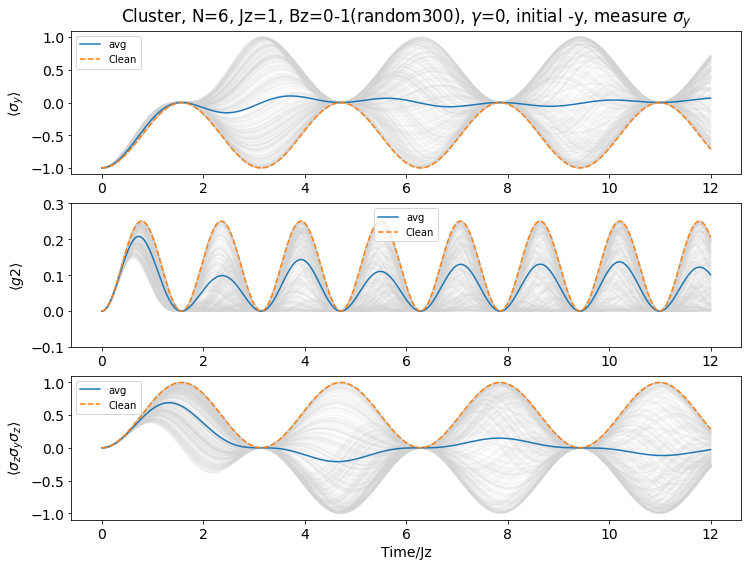

In [206]:
ReSide = 1

g2=np.empty(len(Nran), dtype=object)
Meas=np.empty(len(Nran), dtype=object)
K=np.empty(len(Nran), dtype=object)
for i in range(len(Nran)):
    Meas[i] = ResExp[i][1][ReSide:N-ReSide]
    g2[i] = ResExp[i][0][ReSide:N-1-ReSide]-ResExp[i][1][ReSide:N-1-ReSide]*ResExp[i][1][1+ReSide:N-ReSide]
    K[i] = ResExp[i][2][ReSide:N-2-ReSide]
MeasAvg = Meas.mean(axis=0).mean(axis=0)
g2Avg = g2.mean(axis=0).mean(axis=0)
KAvg = K.mean(axis=0).mean(axis=0)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,9))

for n in range(len(Meas)):
    ax1.plot(tlist, Meas[n][0],'lightgray', alpha=.1)
ax1.plot(tlist, MeasAvg,'-', label='avg')
ax1.plot(tlist, MeasAvgClean,'--', label='Clean')


for n in range(len(g2)):
    ax2.plot(tlist, g2[n][0],'lightgray', alpha=.1)
ax2.plot(tlist, g2Avg,'-', label='avg')
ax2.plot(tlist, g2AvgClean,'--', label='Clean')

for n in range(len(K)):
    ax3.plot(tlist, K[n][0],'lightgray', alpha=.1)
ax3.plot(tlist, KAvg, '-', label='avg')
ax3.plot(tlist, KAvgClean,'--', label='Clean')

ax1.legend(fontsize=10)
ax2.legend(fontsize=10)
ax3.legend(fontsize=10)
ax3.set_xlabel('Time/Jz')
ax1.set_ylabel(r'$\langle\sigma_y\rangle$')
ax2.set_ylabel(r'$\langle g2\rangle$')
ax3.set_ylabel(r'$\langle \sigma_z\sigma_y\sigma_z\rangle$')

ax1.set_title('Cluster, N=6, Jz=1, Bz=0-1(random300), $\gamma$=0, initial -y, measure $\sigma_y$');
ax1.set_ylim([-1.1,1.1])
ax2.set_ylim([-0.1,0.3])
ax3.set_ylim([-1.1,1.1])

# fig.savefig('Outputs/ClusterCorr/'+'Cluster_N=6_Jz=1_Bz=0-1(random300)_gamma=0_initial-y_measure_sigma_y_dpi100.png', dpi=100)

#### Measurement $\langle \sigma_x \rangle$

In [178]:
start_time = time.time()
#
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver

N = 6            # number of spins

Sbasis = Qobj([[1],[0],[0]]).unit() #sigmax, sigmay, sigmaz
CorMea = [
            [Sbasis,Sbasis],
            [Sbasis],
            [Qobj([[0],[0],[1]]),Sbasis,Qobj([[0],[0],[1]])],
         ]

Nran = np.random.rand(300)
ResExp = np.empty(len(Nran), dtype=object)
for i,rani in enumerate(Nran):
    if (i+1)%10 == 0:
        print('\r',i+1,end='')
    # array of spin energy splittings and coupling strengths. here we use
    # uniform parameters, but in general we don't have too
    Bx = 0.0 * np.ones(N)
    Bz = 1.0 * np.ones(N)*(rani)
    Jz = 1.0 * np.ones(N)
    Jx = 0.0 * np.ones(N)
    Jy = 0.0 * np.ones(N)
    
    # dephasing rate
    gamma = 0.00 * np.ones(N)

    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    # psi_list.append((basis(2, 0) + basis(2, 1)).unit())

    for n in range(N):
        # psi_list.append(basis(2,0)) #up |0>
#         psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # |x>
        psi_list.append((basis(2, 0) - 1j*basis(2, 1)).unit()) # |y>

    psi0 = tensor(psi_list)

    tlist = np.linspace(0, 12, 500)
    # 
    ResExp[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea)
print("--- %0.4f seconds ---" % (time.time() - start_time))

 300--- 59.2195 seconds ---


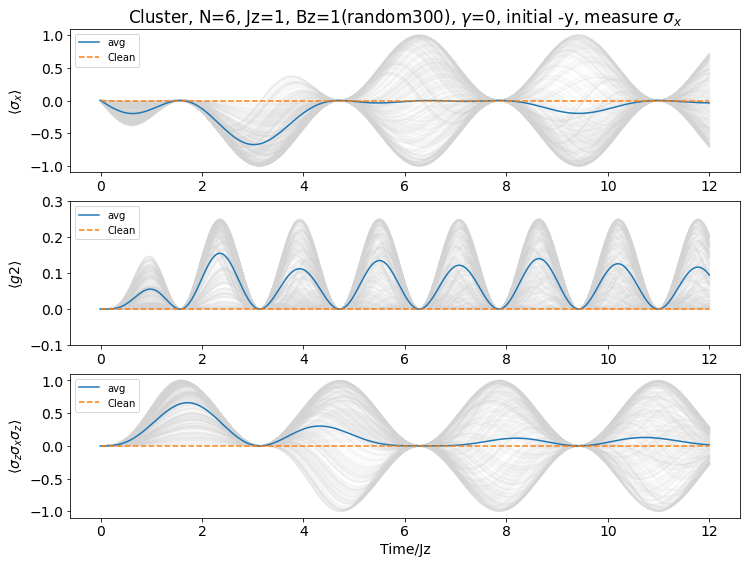

In [185]:
ReSide = 1

g2=np.empty(len(Nran), dtype=object)
Meas=np.empty(len(Nran), dtype=object)
K=np.empty(len(Nran), dtype=object)
for i in range(len(Nran)):
    Meas[i] = ResExp[i][1][ReSide:N-ReSide]
    g2[i] = ResExp[i][0][ReSide:N-1-ReSide]-ResExp[i][1][ReSide:N-1-ReSide]*ResExp[i][1][1+ReSide:N-ReSide]
    K[i] = ResExp[i][2][ReSide:N-2-ReSide]
MeasAvg = Meas.mean(axis=0).mean(axis=0)
g2Avg = g2.mean(axis=0).mean(axis=0)
KAvg = K.mean(axis=0).mean(axis=0)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,9))

for n in range(len(Meas)):
    ax1.plot(tlist, Meas[n][0],'lightgray', alpha=.1)
ax1.plot(tlist, MeasAvg,'-', label='avg')
ax1.plot(tlist, MeasAvgClean,'--', label='Clean')


for n in range(len(g2)):
    ax2.plot(tlist, g2[n][0],'lightgray', alpha=.1)
ax2.plot(tlist, g2Avg,'-', label='avg')
ax2.plot(tlist, g2AvgClean,'--', label='Clean')

for n in range(len(K)):
    ax3.plot(tlist, K[n][0],'lightgray', alpha=.1)
ax3.plot(tlist, KAvg, '-', label='avg')
ax3.plot(tlist, KAvgClean,'--', label='Clean')

ax1.legend(fontsize=10)
ax2.legend(fontsize=10)
ax3.legend(fontsize=10)
ax3.set_xlabel('Time/Jz')
ax1.set_ylabel(r'$\langle\sigma_x\rangle$')
ax2.set_ylabel(r'$\langle g2\rangle$')
ax3.set_ylabel(r'$\langle \sigma_z\sigma_x\sigma_z\rangle$')

ax1.set_title('Cluster, N=6, Jz=1, Bz=1(random300), $\gamma$=0, initial -y, measure $\sigma_x$');
ax1.set_ylim([-1.1,1.1])
ax2.set_ylim([-0.1,0.3])
ax3.set_ylim([-1.1,1.1])

# fig.savefig('Outputs/ClusterCorr/'+'Cluster_N=6_Jz=1_Bz=1(random300)_gamma=0_initial-y_measure_sigma_x.png', dpi=300)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad574db9-57f6-4918-b977-e02cef63b094' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>